### 3D UNet for Image Segmentation in Digital Rock Petrophysics
#### Ahad Momin (ahadmomin16@gmail.com)
##### [GitHub](https://github.com/AhadMomin) | [Website](http://ahadmomin.github.io) |
#### Supervisor: Christoph Arns & Masa Prodanovic
#### Digital Rock Petrophysics

### 3D UNet:
#### The UNet Architecture is inspired by:  | [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) |

#### 3D UNet Model:




This deep neural network is implemented with Tensorflow and Keras functional API, which makes it extremely easy to experiment with different interesting architectures using GPU based enivronment


#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

#### Load the required libraries

The following code loads the required libraries.

Some of the workflow Style is inspired by: Prof Micheal Pyrcz

In [1]:
import os
import random
import tifffile as tff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import notebook, tnrange
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
import cv2

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
import imageio as imi

Using TensorFlow backend.


In [2]:
os.chdir("C:/Users/ahadm/Documents/UNSW Research/image segmentation CNN/UNET CNN/")

In [3]:
image_size = 64
no_slices= 64
epochs= 50
path = "train_data3D64/"
batch_size = 1
ids = next(os.walk(path))[1]
# print(ids)
print("No. of images = ", len(ids))

No. of images =  20


In [4]:
X = np.zeros((len(ids), no_slices, image_size, image_size, 3)).astype(np.float32)
y = np.zeros((len(ids), no_slices, image_size, image_size, 1)).astype(np.float32)

In [5]:
for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    image_sequence = tff.imread(path+id_+"/images/"+id_+".tif")  
    image_sequence = np.expand_dims(image_sequence,axis=3)
    
    segmented= tff.imread(path+id_+"/segmented/"+id_+".tif")
    segmented = np.expand_dims(segmented,axis=3)
    
    X[n] = (image_sequence/255.0)
    y[n] = (segmented/255.0)
    print(image_sequence.shape,image_sequence.dtype, X.shape,X.dtype)

(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32
(64, 64, 64, 1) uint8 (20, 64, 64, 64, 3) float32


In [6]:
print(X.shape,X.dtype,y.shape,y.dtype,image_sequence.shape,y.dtype,segmented.shape,)

(20, 64, 64, 64, 3) float32 (20, 64, 64, 64, 1) float32 (64, 64, 64, 1) float32 (64, 64, 64, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2020)

In [8]:
print("Tomogram dimension in Training = ", X_train.shape,(X_train*255).dtype)
print("Segmented dimension in Training  = ",y_train.shape, y_train.dtype)
print("Tomogram dimension in Testing = ",X_test.shape,X_test.dtype)
print("Segmented dimension in Testing = ",y_test.shape,y_test.dtype)

Tomogram dimension in Training =  (18, 64, 64, 64, 3) float32
Segmented dimension in Training  =  (18, 64, 64, 64, 1) float32
Tomogram dimension in Testing =  (2, 64, 64, 64, 3) float32
Segmented dimension in Testing =  (2, 64, 64, 64, 1) float32


In [9]:
def batch_Norm_Activation(x, BN=True):
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x = keras.layers.Activation("relu")(x)
    return x
def Unet3D(featuremaps):
    inputs = keras.engine.Input((no_slices, image_size, image_size, 3))
    #encoder
    conv1 = keras.layers.Conv3D(featuremaps*1, (3,3,3),activation= None, padding = "same")(inputs)
    conv1 = batch_Norm_Activation(conv1)
    conv1 = keras.layers.Conv3D(featuremaps*1, (3,3,3),activation= None, padding = "same")(conv1)
    conv1 = batch_Norm_Activation(conv1)
    pool1  = keras.layers.MaxPooling3D((2,2,2))(conv1)
    
    conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3 ,3), activation=None, padding="same")(pool1)
    conv2 = batch_Norm_Activation(conv2)
    conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), activation=None, padding="same")(conv2)
    conv2 = batch_Norm_Activation(conv2)
    pool2 = keras.layers.MaxPooling3D((2, 2, 2))(conv2)

    conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), activation=None, padding="same")(pool2)
    conv3 = batch_Norm_Activation(conv3)
    conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), activation=None, padding="same")(conv3)
    conv3 = batch_Norm_Activation(conv3)
    pool3 = keras.layers.MaxPooling3D((2, 2, 2))(conv3)
    
    conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), activation=None, padding ="same")(pool3)
    conv4 = batch_Norm_Activation(conv4)
    conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), activation=None, padding ="same")(conv4)
    conv4 = batch_Norm_Activation(conv4)
    pool4 = keras.layers.MaxPooling3D((2, 2, 2))(conv4)

    # bridge
    convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), activation=None, padding="same")(pool4)
    convm = batch_Norm_Activation(convm)
    convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), activation=None, padding="same")(convm)
    convm = batch_Norm_Activation(convm)
    
    #decoder
    deconv4 = keras.layers.Conv3DTranspose(featuremaps* 8, (2, 2, 2), strides=(2,2,2), padding ="same")(convm)
    uconv4 = keras.layers.concatenate([deconv4, conv4])
    uconv4 = keras.layers.Conv3D(featuremaps* 8, (2 , 2, 2), activation = None, padding= "same")(uconv4)
    uconv4 = batch_Norm_Activation(uconv4)
    uconv4 = keras.layers.Conv3D(featuremaps* 8, (2 , 2, 2), activation = None, padding= "same")(uconv4)
    uconv4 = batch_Norm_Activation(uconv4)

    
    deconv3 = keras.layers.Conv3DTranspose(featuremaps * 4, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv4)
    uconv3 = keras.layers.concatenate([deconv3, conv3])
    uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), activation=None, padding="same")(uconv3)
    uconv3 = batch_Norm_Activation(uconv3)
    uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), activation=None, padding="same")(uconv3)
    uconv3 = batch_Norm_Activation(uconv3)

    
    deconv2 = keras.layers.Conv3DTranspose(featuremaps* 2, (2, 2, 2), strides = (2, 2, 2), padding= "same")(uconv3)
    uconv2 = keras.layers.concatenate([deconv2, conv2])
    uconv2 = keras.layers.Conv3DTranspose(featuremaps* 2, (2, 2, 2), activation = None, padding = "same")(uconv2)
    uconv2 = batch_Norm_Activation(uconv2)
    uconv2 = keras.layers.Conv3DTranspose(featuremaps* 2, (2, 2, 2), activation = None, padding = "same")(uconv2)
    uconv2 = batch_Norm_Activation(uconv2)


    deconv1 = keras.layers.Conv3DTranspose(featuremaps * 1, (2, 2 ,2), strides=(2, 2, 2), padding="same")(uconv2)
    uconv1 = keras.layers.concatenate([deconv1, conv1])
    uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2, 2), activation=None, padding="same")(uconv1)
    uconv1 = batch_Norm_Activation(uconv1)
    uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2,2), activation=None, padding="same")(uconv1)
    uconv1 = batch_Norm_Activation(uconv1)

    
    output_layer = keras.layers.Conv3D(1, (1, 1 ,1), padding="same", activation="sigmoid")(uconv1)
    model = keras.models.Model(inputs, output_layer)
    return model

In [10]:
model= Unet3D(64)
print(model.inputs)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd, loss="mean_squared_error", metrics=["acc"])
model.summary()

[<tf.Tensor 'input_1:0' shape=(None, 64, 64, 64, 3) dtype=float32>]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 64, 3 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 64, 64, 6 5248        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 64, 6 256         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64, 6 0           batch_normalization_1[0][0]      
________________________

In [11]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-3dtest1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [13]:
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,callbacks=callbacks,\
                    validation_data=(X_test, y_test))

Train on 18 samples, validate on 2 samples
Epoch 1/50
18/18 [==============================] - 29s 2s/step - loss: 0.1059 - acc: 0.6908 - val_loss: 0.1284 - val_acc: 0.8293

Epoch 00001: val_loss improved from inf to 0.12839, saving model to model-3dtest1.h5
Epoch 2/50
18/18 [==============================] - 24s 1s/step - loss: 0.0191 - acc: 0.8065 - val_loss: 0.0793 - val_acc: 0.8293

Epoch 00002: val_loss improved from 0.12839 to 0.07932, saving model to model-3dtest1.h5
Epoch 3/50
18/18 [==============================] - 26s 1s/step - loss: 0.0114 - acc: 0.8073 - val_loss: 0.0567 - val_acc: 0.8293

Epoch 00003: val_loss improved from 0.07932 to 0.05671, saving model to model-3dtest1.h5
Epoch 4/50
18/18 [==============================] - 27s 1s/step - loss: 0.0092 - acc: 0.8074 - val_loss: 0.0454 - val_acc: 0.8293

Epoch 00004: val_loss improved from 0.05671 to 0.04538, saving model to model-3dtest1.h5
Epoch 5/50
18/18 [==============================] - 26s 1s/step - loss: 0.0081 - 


Epoch 00038: val_loss improved from 0.00379 to 0.00333, saving model to model-3dtest1.h5
Epoch 39/50
18/18 [==============================] - 24s 1s/step - loss: 0.0037 - acc: 0.8074 - val_loss: 0.0034 - val_acc: 0.8293

Epoch 00039: val_loss did not improve from 0.00333
Epoch 40/50
18/18 [==============================] - 25s 1s/step - loss: 0.0037 - acc: 0.8074 - val_loss: 0.0032 - val_acc: 0.8293

Epoch 00040: val_loss improved from 0.00333 to 0.00319, saving model to model-3dtest1.h5
Epoch 41/50
18/18 [==============================] - 25s 1s/step - loss: 0.0037 - acc: 0.8074 - val_loss: 0.0034 - val_acc: 0.8293

Epoch 00041: val_loss did not improve from 0.00319
Epoch 42/50
18/18 [==============================] - 25s 1s/step - loss: 0.0036 - acc: 0.8074 - val_loss: 0.0031 - val_acc: 0.8293

Epoch 00042: val_loss improved from 0.00319 to 0.00310, saving model to model-3dtest1.h5
Epoch 43/50
18/18 [==============================] - 24s 1s/step - loss: 0.0037 - acc: 0.8074 - val_lo

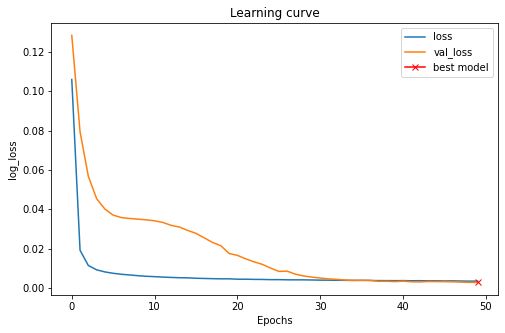

In [14]:
plt.figure(figsize=(8, 5))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [15]:
model.load_weights('model-3dtest1.h5')
model.evaluate(X_test, y_test, verbose=1) 


2/2 [==============================] - 4s 2s/step


[0.0027675125747919083, 0.8292827606201172]

In [18]:
preds_test = model.predict(X_test, verbose=1)
preds_train= model.predict(X_train[0:2], verbose=1)

2/2 [==============================] - 1s 282ms/step


In [19]:
print(X_train.shape,X.shape)
print(X_test.shape)
print(preds_test.shape)

(18, 64, 64, 64, 3) (20, 64, 64, 64, 3)
(2, 64, 64, 64, 3)
(2, 64, 64, 64, 1)


In [20]:
def save_sample(X, y, preds, r=None):
    if r is None:
        r = random.randint(0, len(X))
        print(r)
        
    X1= X[r,...,0].squeeze()
    tff.imwrite('tomogram1.tif', X1 , imagej=True)
    print(X1.shape,X1.dtype)
        
    y1 = y[r].squeeze()
    tff.imwrite('GR1.tif', y1 , imagej=False)
    print(y1.shape,y1.dtype)

    preds1=preds[r].squeeze()
    tff.imwrite('predicted1.tif',preds1, imagej=True)
    print(preds1.shape,preds1.dtype)


In [21]:
save_sample(X_test,y_test,preds_test,r=0)

(64, 64, 64) float32
(64, 64, 64) float32
(64, 64, 64) float32


In [ ]:
save_sample(X_train,y_train,preds_train, r=3)